# 4. Semantic Space Construction

In this notebook, the semantic space is constructed by which nouns in the Hebrew Bible can be compared for similarity. The steps are:

1) Gather data in the Hebrew Bible for all nouns in narrative clauses that function either as a subject, object, or coordinate noun within a subj/obj phrase. Another restriction is applied that requires the noun have a minimum occurrence frequency. For every noun that meets these requirements, record the verb or noun that it collocates with. Also record the target noun's role and the collocated word's role. E.g. "Subject -> verb" or "Subject -> coordinate.noun." In addition, for every verb the stem is also recorded. An example of a full tag is: "Subj -> HLK[.qal" (הלך in the qal). 

2) Apply frequency adjustments to all of the cooccurrence counts. Since different words in a text occur with many different frequencies, statistical adjustments are commonly used in semantic space constructions. This notebook experiments with the [log-likelihood](http://aclweb.org/anthology/J93-1003) and [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Applications) scores. 

3) Apply [principle component analysis](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/) (PCA) to compress all of the data points (cooccurrence counts) for each word into two, representative values. These values present the most informative "angle" from which to view the word cooccurrence data, i.e. the "angle" which presents the greatest amount of variation. PCA allows us to plot the words on a graph and visually inspect any potential clusters.

4) Apply similarity measures and clustering algorithms to group nouns together. Similarity measures are algorithms which compare the data for all nouns with each other to determine a distance. In other words, it calculates how similar the terms are to each other. A [clustering algorithm](https://en.wikipedia.org/wiki/Cluster_analysis) can use these distances to group the nouns into different clusters. A silhouette diagram can be used for partioning cluster methods to determine the ideal number of clusters (`k`). 

The results in this notebook are exploratory and rough. There are a few points of improvement that are needed going forward. For step 1, a more sophisiticated system of context selection must be designed. The system should not only consider predicate/object/subject/coordinate relations, but also complements and other descriptors (e.g. constructs, adjectives, adverbs, etc.). In [Padó and Lapata 2007](https://www.mitpressjournals.org/doi/pdf/10.1162/coli.2007.33.2.161), the inspiration for this experiment, a variety of paths and relationships are considered using a dependency tree. Dependency trees describe the precise relationships between words within a clause. For instance, a clause's verb is in a relation with its object; descriptors such as adjectives are in dependent relations with their described nouns, etc.. The ETCBC data does not contain such fine-grained encodings. But there is an ETCBC [tree module](https://github.com/ETCBC/lingo) (Dirk Roorda) which contains constituency trees in [Penn Treebank](https://en.wikipedia.org/wiki/Treebank) format. These trees may be useful for approximating the Padó and Lapata method. 

## Load Functions

In [18]:
import collections, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from project_code.semspace import SemSpace

# Build Semantic Space

Import SemSpace, the class which contains the code for all of the experiments. This class is also easily maneuverable for alternate experiment parameters.

In [2]:
semspace = SemSpace()

# give report on space size
print('Size of the space:')
for name, count in zip(('cooccurrences', 'target words'), semspace.raw.shape):
    print('\t', count, name)

Size of the space:
	 1277 cooccurrences
	 364 target words


### Import BHSA Helpers & Text-Fabric

In [3]:
get_lex = semspace.get_lex # returns a lex node
F, T, L = semspace.tf_api.F, semspace.tf_api.T, semspace.tf_api.L # Text Fabric api with BHSA data

### Raw and Adjusted Frequency Matrices

In [4]:
# Adjusted Counts (and raw counts)
cooccurrences = semspace.raw
test_ll = semspace.loglikelihood
test_pmi = semspace.pmi

# give e.g.
test_ll.head(5)

,<BD/,<BDH/,<CN/,<CTRT/,<DH/,<DWT/,<FB/,<GL/,<GLH=/,<JN/,...,YPJR/,YR=/,YWM/,Z<QH/,ZBX/,ZHB/,ZJT/,ZQN/,ZR</,ZRW</
Objc.<BD[.hif,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Objc.<BD[.qal,0.0,22.276992,0.0,14.993021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Objc.<BR[.hif,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Objc.<BR[.qal,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Objc.<DH[.qal,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.120937,0.0,0.0,0.0,0.0


## Size of Observations

### Raw Frequencies

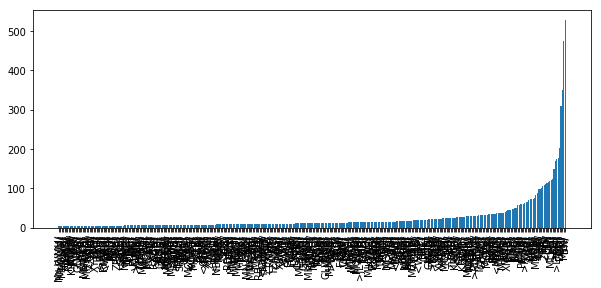

In [5]:
plt.figure(figsize=(10, 4))
plt.bar(cooccurrences.sum().sort_values().index, cooccurrences.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Log Likelihood Adjusted Frequencies

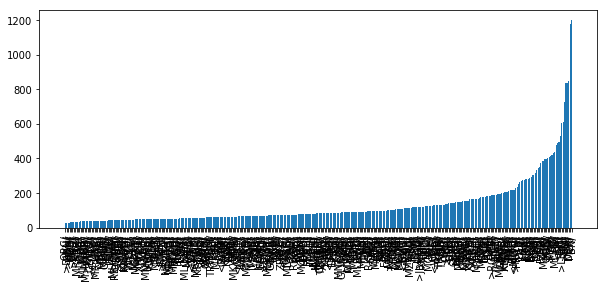

In [6]:
plt.figure(figsize=(10, 4))
plt.bar(test_ll.sum().sort_values().index, test_ll.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### PMI Adjusted Frequencies

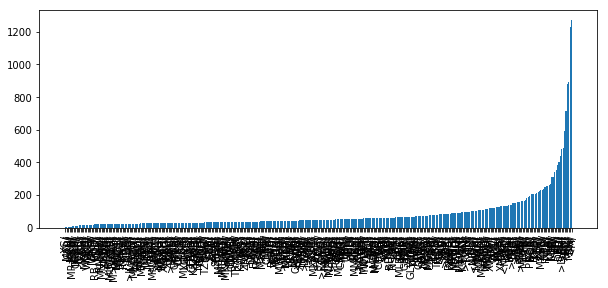

In [7]:
plt.figure(figsize=(10, 4))
plt.bar(test_pmi.sum().sort_values().index, test_pmi.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Top Counts

Examine the top counts to see how the frequency adjustments affect the overal values.

**Top Raw Counts**

In [8]:
cooccurrences.sum().sort_values(ascending=False).head(10)

BN/       527.0
MLK/      474.0
<M/       349.0
>JC/      310.0
DBR/      202.0
BJT/      177.0
>LHJM/    174.0
>CH/      170.0
>RY/      150.0
KLJ/      123.0
dtype: float64

**Top Log-likelihood**

In [9]:
test_ll.sum().sort_values(ascending=False).head(10)

BN/       1197.357523
MLK/      1174.450140
DBR/       847.215176
CM/        833.156208
<M/        832.998743
>RY/       723.123459
>JC/       609.945763
>LHJM/     601.709137
BJT/       529.552516
>P/        495.887465
dtype: float64

**Top PMI counts**

In [10]:
test_pmi.sum().sort_values(ascending=False).head(10)

<M/       1268.267262
BN/       1231.236462
MLK/       893.195316
>JC/       878.280603
BJT/       712.513161
>RY/       590.426221
>CH/       489.512485
>LHJM/     483.752250
KLJ/       440.378112
DBR/       398.420895
dtype: float64

## Vector Space Construction with PCA

Use Principal Component Analysis (PCA) to look at the data.

### PCA Assignments from SemSpace

In [11]:
pca_raw = semspace.pca_raw
pca_ll = semspace.pca_ll
pca_pmi = semspace.pca_pmi

## PCA with Raw Counts

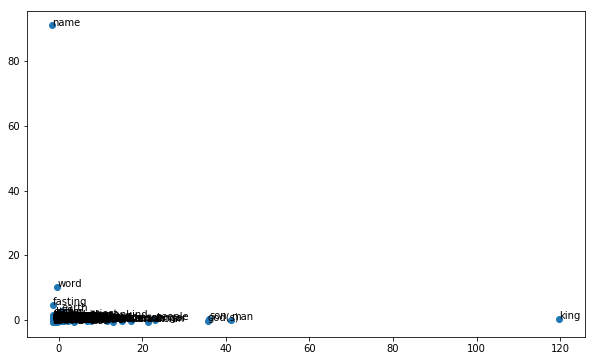

In [12]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_raw[i, 0], pca_raw[i, 1]))

### Log-likelihood Vector Space

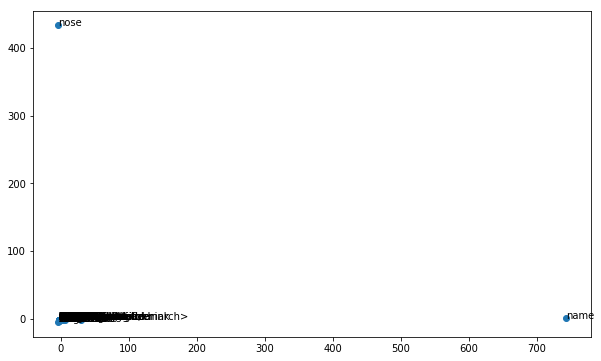

In [13]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

#plt.axis([-30, 30, -50, 100])

# annotate
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space.png')

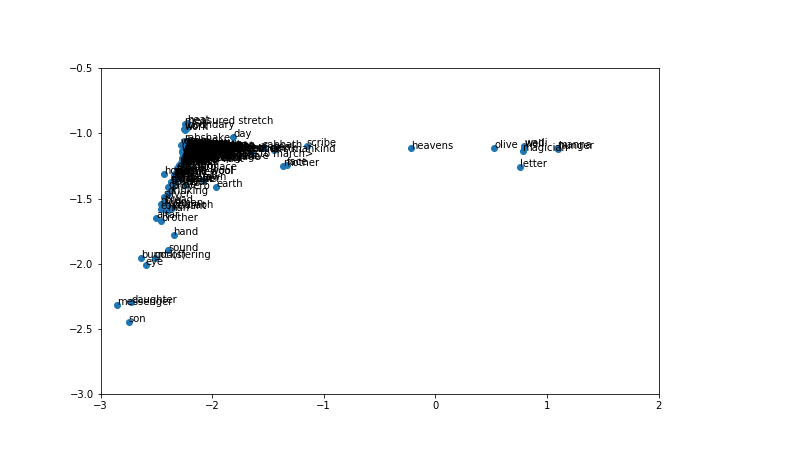

In [14]:
# closer view of LL
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-3, 2, -3, -0.5])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space_zoom.png')

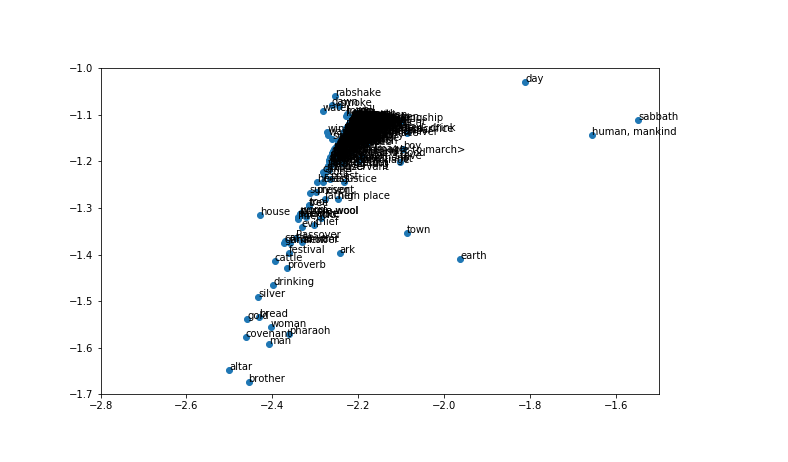

In [15]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-2.8, -1.5, -1.7, -1])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space_zoom2.png')

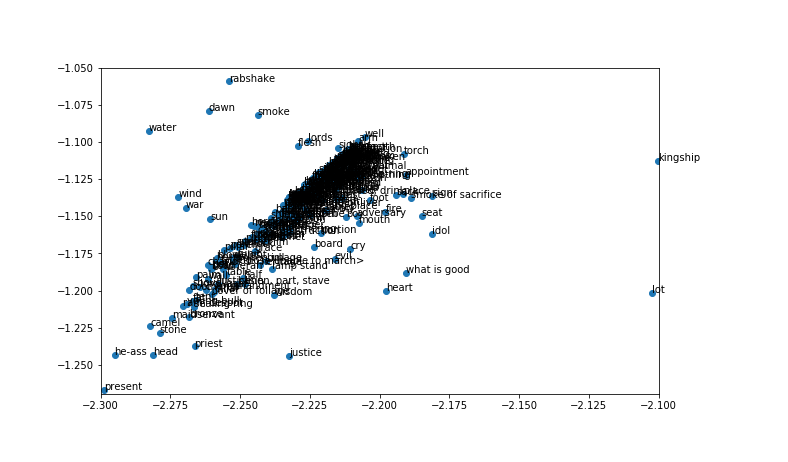

In [16]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-2.3, -2.1, -1.27, -1.05])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space_zoom3.png')

### Log-Likelihood, 3D Analysis

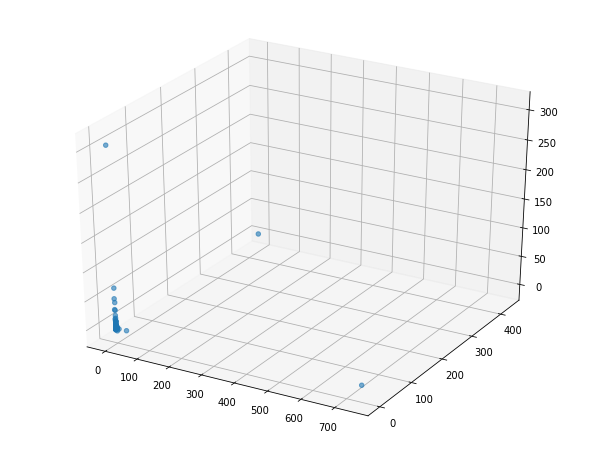

In [19]:
pca_ll_3D = semspace.pca_ll_3d

x = pca_ll_3D[:, 0]
y = pca_ll_3D[:, 1]
z = pca_ll_3D[:, 2]
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(x, y, z, marker='o', alpha=0.6)
    
plt.show()

### Pointwise Mutual Information

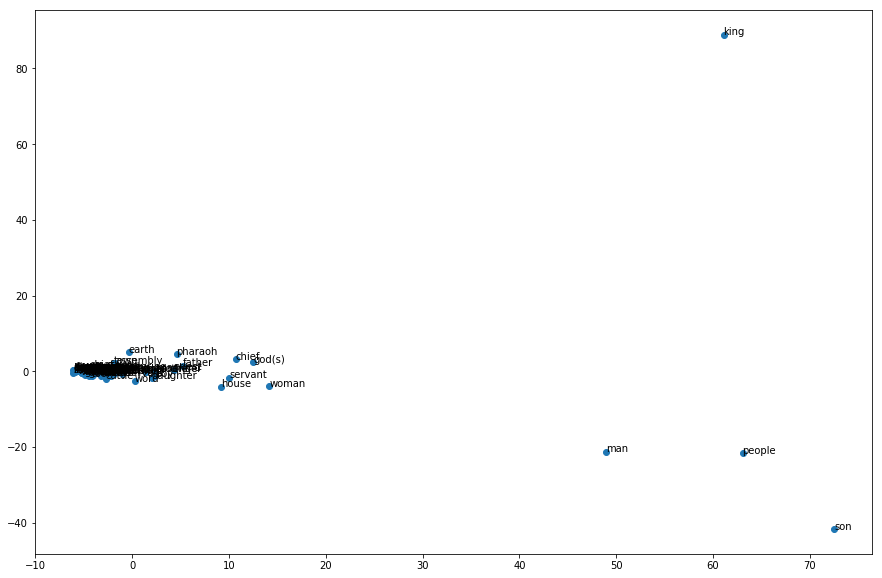

In [271]:
pca_pmi = pca.fit_transform(test_pmi.T.values)

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_pmi.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_pmi[i, 0], pca_pmi[i, 1]))

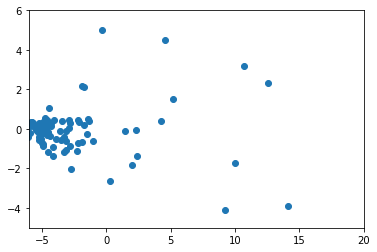

In [272]:
cluster1 = [-5, 20, -10, 10]
cluster2 = [-0.8, 3, -1.25, 1.5]
[-6, 20, -3, 20]

#plt.axis([-1, 2, -3, 5])
plt.axis([-6, 20, -5, 6])

# create a scatter plot of the projection
plt.figure(1, figsize=(15, 10))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])


## Distances and Similarities

Use cosine similarity to construct a similarity matrix.

In [278]:
row_col = [F.lex.v(get_lex(w)) + ' ' + '"' + F.gloss.v(get_lex(w)) + '"' for w in cooccurrences.columns]

# distances, non-pca
ll_dists = pairwise_distances(test_ll.T.values, metric='cosine')
pmi_dists = pairwise_distances(test_pmi.T.values, metric='cosine')
raw_dists = pairwise_distances(cooccurrences.T.values, metric='cosine')

# distances, pca
pca_dists_ll = pairwise_distances(pca_ll, metric='cosine')
pca_dists_pmi = pairwise_distances(pca_pmi, metric='cosine')
pca_dists_raw = pairwise_distances(pca_raw, metric='cosine')

# distance matrices
ll_dist_matrix = pd.DataFrame(ll_dists, columns=row_col, index=row_col)
pmi_dist_matrix = pd.DataFrame(pmi_dists, columns=row_col, index=row_col)
raw_dist_matrix = pd.DataFrame(raw_dists, columns=row_col, index=row_col)

# similarity matrices
# distance matrices
ll_sim_matrix = ll_dist_matrix.apply(lambda x: 1-x)
pmi_sim_matrix = pmi_dist_matrix.apply(lambda x: 1-x)
raw_sim_matrix = raw_dist_matrix.apply(lambda x: 1-x)

ValueError: Shape of passed values is (95, 95), indices imply (385, 385)

Obtain A Similarity Matrix

In [277]:
row_col = [F.lex.v(get_lex(w)) + ' ' + '"' + F.gloss.v(get_lex(w)) + '"' for w in test_ll.columns]

ll_dist_matrix = pd.DataFrame(pairwise_distances(test_ll.T.values, metric='cosine'),
                        columns=row_col, 
                        index=row_col
                        )

ll_similar = ll_dists.apply(lambda x: 1-x)
pmi_similar = pmi_dists.apply(lambda x: 1-x)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

Examine matches to most common nouns.

In [275]:
export = pmi_similar

common = export.sum().sort_values(ascending=False).head(50)

for i, noun in enumerate(common.index):

    gloss = F.gloss.v(get_lex(noun))
    key = noun + ' ' + '"' + gloss + '"'
    
    #print(key)
    #print(round(ll_similar[key].sort_values(ascending=False)[1:10], 3))
    round(export[key].sort_values(ascending=False)[1:], 3).to_csv(f'data/{gloss}_similarities.csv')
    #print()

NameError: name 'pmi_similar' is not defined

In [260]:
round(ll_similar['MJM/ "water"'].sort_values(ascending=False)[1:10], 3) # just a random term to test, "water"

JJN/ "wine"           0.479
MKH/ "blow"           0.082
BKR/ "first-born"     0.074
RB_CQH/ "rabshake"    0.046
B>R/ "well"           0.042
KD/ "pitcher"         0.036
<FB/ "herb"           0.027
SWS/ "horse"          0.027
NXL/ "wadi"           0.025
Name: MJM/ "water", dtype: float64

In [230]:
def show_sim(testw, test):    
    
    '''
    Return a comparison of similar words for a given test word.
    !No longer needed — see pairwise_distances!
    '''
    
    test_sims = []
    vectA = test[testw]

    for word in test.columns:

        if word  == testw:
            continue

        vectB = test[word]

        cosine = sum(vectA * vectB) / (math.sqrt(sum(vectA*vectA)) * math.sqrt(sum(vectB*vectB)))

        test_sims.append((cosine, word))

    results = []
        
    for score, word in sorted(test_sims, reverse=True)[:25]:

        lex = [lex for lex in F.otype.s('lex') if F.lex.v(lex) == word][0]

        results.append([score, word, F.gloss.v(lex), F.freq_lex.v(lex)])
        
    return(results)

## Distance Metrics